I will  choose Linear Regression and Statsmodels OLS because for linear regression, the influence of removing a point just tied to the residual and leverage. But for ridge and lasso you also have to consider λ which will take more work so not as efficient.

I pick Statsmodels because it has the built in influence diagnostics workflow for it is less likely to make a mistake.

In [3]:
import pandas as pd
import numpy as np

# For OLS + Cook's Distance diagnostics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence


In [4]:
DATA_PATH = "usina_with_outliers.csv"
df = pd.read_csv(DATA_PATH)
display(df.head(), df.info(), df.describe())
if df.isna().sum().any():
  df = df.dropna()
X = df.drop(columns=["PE"])
y = df["PE"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()
influence = OLSInfluence(model)
cook_d = influence.cooks_distance[0]
n = len(df)
outlier_index = df.index[np.where(cook_d > (4 / n))]
print(outlier_index)
df_clean = df.drop(index = outlier_index)
print(df_clean.info)
df_clean.to_csv("usina.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


None

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.618518,54.250021,1013.288871,73.308978,454.407820
std,8.256412,13.993655,6.636609,16.094499,18.760047
min,-39.174839,-38.397358,959.607298,-53.091613,327.528030
25%,13.480000,41.670000,1009.077500,63.227500,439.730000
50%,20.320000,52.080000,1012.950000,74.955000,451.620000
75%,25.732500,66.540000,1017.320000,84.882500,468.530000
max,77.344839,155.117358,1064.772702,187.691613,590.091970


Index([  35,   49,  112,  339,  402,  418,  511,  526,  606,  875,
       ...
       9153, 9219, 9241, 9245, 9406, 9408, 9463, 9472, 9510, 9525],
      dtype='int64', length=120)
<bound method DataFrame.info of          AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9448 rows x 5 columns]>


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
def evaluate_regression(model, X_train, X_test, y_train, y_test):
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)

    results = {
        "MSE_train": mean_squared_error(y_train, pred_train),
        "MSE_test":  mean_squared_error(y_test, pred_test),
        "MAE_train":  mean_absolute_error(y_train, pred_train),
        "MAE_test":   mean_absolute_error(y_test, pred_test),
        "R2_train":   r2_score(y_train, pred_train),
        "R2_test":    r2_score(y_test, pred_test),
    }
    return results

In [14]:
df2 = pd.read_csv("usina.csv")
X2 = df2.drop(columns=["PE"])
y2 = df2["PE"]
X2 = sm.add_constant(X2)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 4, shuffle = True
    )
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size = 0.3, random_state = 4, shuffle = True
    )
model_linear = LinearRegression().fit(X_train, y_train) #with outlier
model_linear2 = LinearRegression().fit(X2_train, y2_train) #without outlier
results = []
result2 = []
results.append({
  "Linear Regression":  evaluate_regression(model_linear, X_train, X_test, y_train, y_test)

})
result2.append({
   "Linear Regression": evaluate_regression(model_linear2, X2_train, X2_test, y2_train, y2_test)
})


for lam in [0.01, 0.1, 1, 10, 100]:
  model_ridge = Ridge(alpha = lam).fit(X_train, y_train)
  model_ridge2 = Ridge(alpha = lam).fit(X2_train, y2_train)
  model_lasso = Lasso(alpha = lam).fit(X_train, y_train)
  model_lasso2 = Lasso(alpha = lam).fit(X2_train, y2_train)

  Name = "Ridge λ = " + str(lam)
  Name2 = "Lasso λ = " + str(lam)
  results.append({
      Name : evaluate_regression(model_ridge, X_train, X_test, y_train, y_test),
      Name2 : evaluate_regression(model_lasso, X_train, X_test, y_train, y_test),
  })
  result2.append({
      Name : evaluate_regression(model_ridge2, X2_train, X2_test, y2_train, y2_test),
      Name2 : evaluate_regression(model_lasso2, X2_train, X2_test, y2_train, y2_test),
  })

def to_results_table(results_list):
    rows = []

    for block in results_list:  # each block is like {"Ridge λ = 0.1": {...}, "Lasso λ = 0.1": {...}}
        for model_name, metrics in block.items():

            # format model name to match the PDF style
            if model_name.startswith("Ridge"):
                lam = model_name.split("=")[-1].strip()
                pretty_name = f"Ridge (λ={lam})"
            elif model_name.startswith("Lasso"):
                lam = model_name.split("=")[-1].strip()
                pretty_name = f"Lasso (λ={lam})"
            else:
                pretty_name = model_name  # "Linear Regression"

            rows.append({
                "Model": pretty_name,
                "Train MSE": metrics["MSE_train"],
                "Train MAE": metrics["MAE_train"],
                "Train R^2":  metrics["R2_train"],
                "Test MSE":  metrics["MSE_test"],
                "Test MAE":  metrics["MAE_test"],
                "Test R^2":   metrics["R2_test"],
            })

    df_table = pd.DataFrame(rows)

    # sort to match the example ordering: Linear, Ridge increasing λ, Lasso increasing λ
    def sort_key(m):
        if m == "Linear Regression":
            return (0, 0.0)
        if m.startswith("Ridge"):
            lam = float(m.split("λ=")[-1].rstrip(")"))
            return (1, lam)
        if m.startswith("Lasso"):
            lam = float(m.split("λ=")[-1].rstrip(")"))
            return (2, lam)
        return (9, 0.0)

    df_table = df_table.sort_values(by="Model", key=lambda s: s.map(sort_key)).reset_index(drop=True)
    return df_table


table_with_outliers = to_results_table(results)
table_without_outliers = to_results_table(result2)

display(table_with_outliers)
display(table_without_outliers)







,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2
0,Linear Regression,139.806235,5.561363,0.612298,90.414432,5.309631,0.727341
1,Ridge (λ=0.01),139.806235,5.561363,0.612298,90.414433,5.309631,0.727341
2,Ridge (λ=0.1),139.806235,5.561363,0.612298,90.414442,5.309631,0.727341
3,Ridge (λ=1),139.806235,5.561367,0.612298,90.414535,5.309635,0.727341
4,Ridge (λ=10),139.806235,5.561407,0.612298,90.415462,5.309680,0.727338
5,Ridge (λ=100),139.806240,5.561801,0.612298,90.424726,5.310122,0.727310
6,Lasso (λ=0.01),139.806238,5.561505,0.612298,90.413271,5.309760,0.727345
7,Lasso (λ=0.1),139.806652,5.564005,0.612297,90.431057,5.312338,0.727291
8,Lasso (λ=1),139.849034,5.590999,0.612179,90.649102,5.341258,0.726633
9,Lasso (λ=10),142.644607,5.913779,0.604427,95.459504,5.651978,0.712127


,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2
0,Linear Regression,20.031267,3.602568,0.931340,20.018926,3.619247,0.930306
1,Ridge (λ=0.01),20.031267,3.602568,0.931340,20.018926,3.619247,0.930306
2,Ridge (λ=0.1),20.031267,3.602568,0.931340,20.018927,3.619247,0.930306
3,Ridge (λ=1),20.031267,3.602571,0.931340,20.018944,3.619250,0.930306
4,Ridge (λ=10),20.031268,3.602601,0.931340,20.019111,3.619280,0.930306
5,Ridge (λ=100),20.031352,3.602913,0.931339,20.020857,3.619576,0.930299
6,Lasso (λ=0.01),20.031271,3.602540,0.931340,20.018602,3.619178,0.930307
7,Lasso (λ=0.1),20.031834,3.603130,0.931338,20.020308,3.619375,0.930301
8,Lasso (λ=1),20.094342,3.613234,0.931123,20.092463,3.625013,0.930050
9,Lasso (λ=10),25.780784,4.101245,0.911632,25.758218,4.069366,0.910325


question2:  After removed the outlier it has significantly reduced the train and test error
The dataset without outlier shows better generaliation
But Ridge and Lasso does not appear to help compare with the linear regression

question3: I choose the linear regression because for linear regression has more certainity for each coefficient which could lead to more reliable coefficient.

I choose the stats models because it directly provide standard errors and makes the reliability readoning transparent and easy to show.

I would scale IVs for this
scaling IVs helps to get a comparable unit scale as differences in units can make coefficient magnitudes and their standard errors hard to compare directly.

In [15]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("usina.csv")
X = df.drop(columns=["PE"])
y = df["PE"]
X = StandardScaler().fit_transform(X)
X_const = sm.add_constant(X)
sm.OLS(y, X_const).fit()
display(model.summary(), model.bse, model.conf_int(), model.params)
largest = model.bse.idxmax()
smallest = model.bse.idxmin()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     4416.
Date:                Fri, 30 Jan 2026   Prob (F-statistic):               0.00
Time:                        05:56:42   Log-Likelihood:                -36621.
No. Observations:                9568   AIC:                         7.325e+04
Df Residuals:                    9563   BIC:                         7.329e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.7845     19.524      2.447      0.014       9.512      86.057
AT            -1.1528      0.022    -51.515      0.000      -1.197      -1.109
V             -0.3738      0.012    -31.957      0.000      -0.397      -0.351
AP             0.4449      0.019     23.392      0.000       0.408       0.482
RH            -0.0175      0.008     -2.184      0.029      -0.033      -0.002
==============================================================================
Omnibus:                     5308.159   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7029536.210
Skew:                           1.123   Prob(JB):                         0.00
Kurtosis:                     135.769   Cond. No.                     1.75e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,0
const,19.524433
AT,0.022379
V,0.011696
AP,0.019019
RH,0.008035


,0,1
const,9.512479,86.056538
AT,-1.196708,-1.108974
V,-0.396679,-0.350827
AP,0.407610,0.482171
RH,-0.033297,-0.001796


,0
const,47.784508
AT,-1.152841
V,-0.373753
AP,0.444891
RH,-0.017546


reading from the data the most reliable predictor is RH with smallest std err 0.0080 narrowest CI
and least reliable predictor is AT with the largest std err 0.0224 and the widest CI

question4:  I will still choose Linear Regression because ridge and Lasso change coefficient magnitudes through regularization so the importance can shift depending on lam.

I choose scikit_learn because it has the scaling feature for this case we need standardized coefficients

I would scale the IVs
Because without scaling coefficient magnitudes are not directly comparable with the different units.

In [18]:
df = pd.read_csv("usina.csv")
X = df.drop(columns=["PE"])
y = df["PE"]
X_scaled = StandardScaler().fit_transform(X)
model = LinearRegression().fit(X_scaled, y)
abs_coef = np.abs(model.coef_)
feature_names = X.columns
series = pd.Series(abs_coef, index=feature_names).sort_values(ascending=False)
display(series.index[0], series.index[-1])

'AT'

'AP'

The most important feature is AT and least important is AP

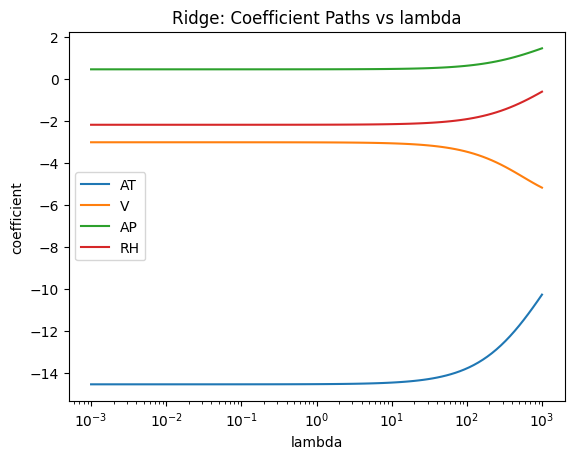

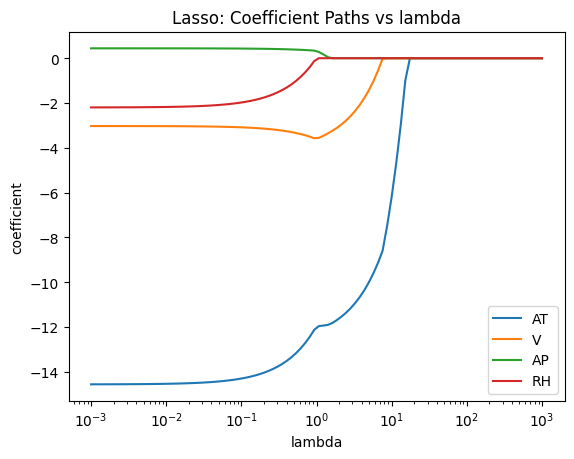

In [19]:
import matplotlib.pyplot as plt

lams = np.logspace(-3, 3, 100)

ridge_coefs = np.zeros((len(lams), X_scaled.shape[1]))
lasso_coefs = np.zeros((len(lams), X_scaled.shape[1]))

for i, lam in enumerate(lams):
    model_ridge = Ridge(alpha=lam).fit(X_scaled, y)
    model_lasso = Lasso(alpha=lam, max_iter=10000).fit(X_scaled, y)

    ridge_coefs[i, :] = model_ridge.coef_
    lasso_coefs[i, :] = model_lasso.coef_

# Plot Ridge
plt.figure()
for j, name in enumerate(feature_names):
    plt.semilogx(lams, ridge_coefs[:, j], label=name)
plt.xlabel("lambda")
plt.ylabel("coefficient")
plt.title("Ridge: Coefficient Paths vs lambda")
plt.legend()
plt.show()

# Plot Lasso
plt.figure()
for j, name in enumerate(feature_names):
    plt.semilogx(lams, lasso_coefs[:, j], label=name)
plt.xlabel("lambda")
plt.ylabel("coefficient")
plt.title("Lasso: Coefficient Paths vs lambda")
plt.legend()
plt.show()

question5

When lam increase for Ridge smoothly approaching zero but won't reach exactly 0, when lam increase for Lasso all the coefficient approach zero rapidly and get extactly zero.

Ridge is better because the L2 penalty stabilize the solution shrinking correlated coefficients and reducing variance.

Lasso is better for feature selection because L1 penalty can set the coefficients to exactly 0 and removing features from the model.